## **Pre-training**
---
---

In [1]:
%%capture
!pip install self-supervised
!pip install fastai

In [2]:
import fastai
fastai.__version__

'2.2.7'

In [3]:
from fastai.vision.all import *
torch.backends.cudnn.benchmark = True
WANDB = False
if WANDB:
    try:
        from fastai.callback.wandb import WandbCallback
        import wandb
    except:
        raise ImportError("Please run '!pip install wandb' on another cell to install wandb")

In [4]:
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.vision.swav import *

In [5]:
bs, resize, size = 256, 92, 92

In [6]:
def get_dls(size, bs, workers=None):
    def dummy_label(o): return 0
    files = map(lambda img: f'./dataset/unlabeled/{img}', os.listdir('./dataset/unlabeled/'))
    files=list(files)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)],[dummy_label,Categorize()]]
    
    dsets = Datasets(files, tfms=tfms,splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [7]:
dls = get_dls(resize, bs)

In [8]:
arch = "resnet34"
encoder = create_encoder(arch, pretrained=False, n_in=3)

In [9]:
K = bs*2**4

In [10]:
if WANDB:
    xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"SWAV"}
    wandb.init(project="self-supervised-imagewang", config=xtra_config);

In [11]:
model = create_swav_model(encoder)

In [12]:
aug_pipelines = get_swav_aug_pipelines(num_crops=[2,6],
                                       crop_sizes=[size,int(3/4*size)], 
                                       min_scales=[0.25,0.2],
                                       max_scales=[1.0,0.35],
                                       rotate=True, rotate_deg=10, jitter=True, bw=True, blur=False)

In [13]:
cbs=[SWAV(aug_pipelines, crop_assgn_ids=[0,1], K=K, queue_start_pct=0.5, temp=0.1)]
if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]

In [14]:
learn = Learner(dls, model, cbs=cbs)

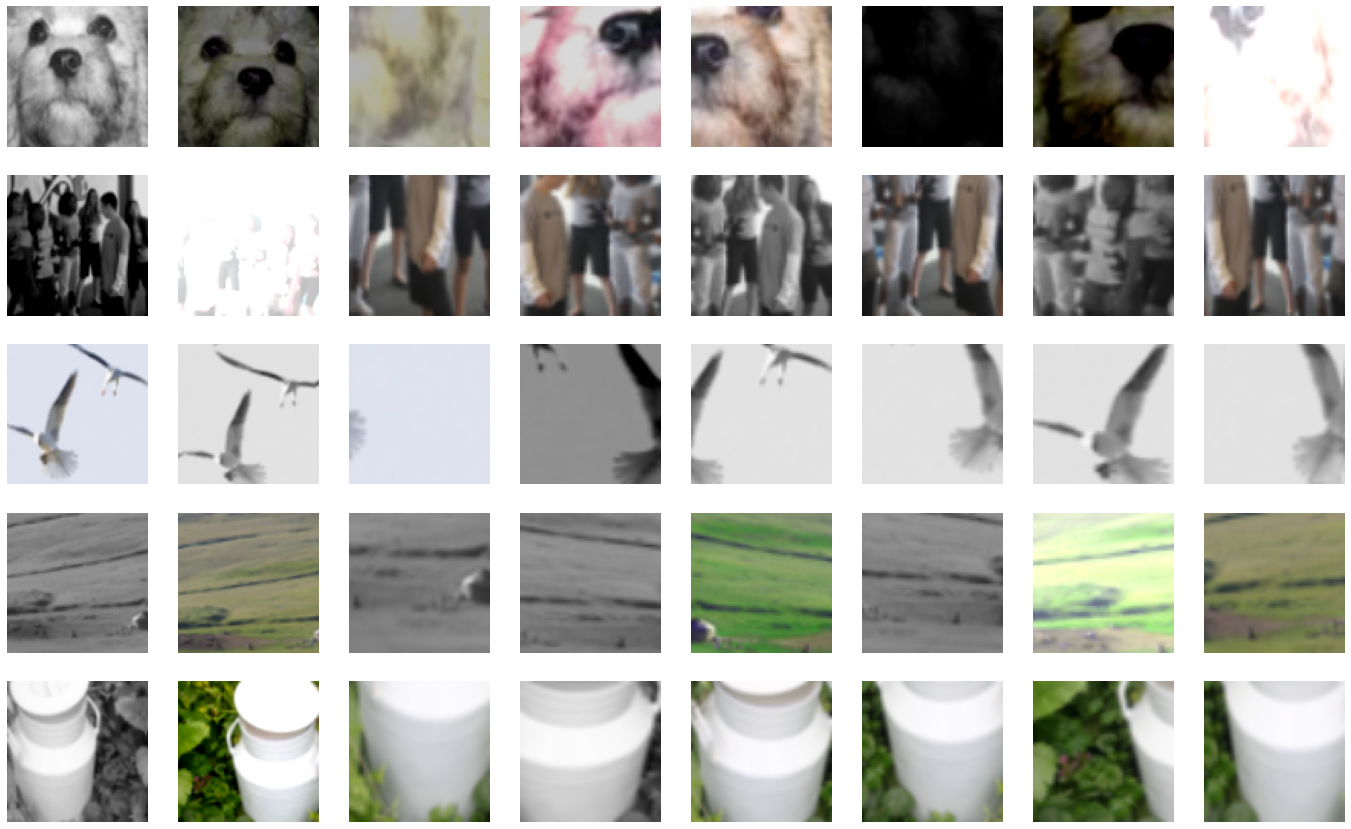

In [15]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.swav.show(n=5);

In [16]:
learn.to_fp16();

In [17]:
lr,wd,epochs=1e-2,1e-2,6

In [18]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,8.006385,8.006357,52:10
1,8.006378,8.006355,42:35
2,8.006384,8.006357,41:43
3,7.801236,7.989349,41:46
4,7.486388,7.519237,42:15
5,7.262405,nan,42:06


In [19]:
save_name = f'swav_pretrain_sz{size}_epc{epochs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'encoder.pth')
torch.save(learn.model.encoder.state_dict(), 'encoder.pth')

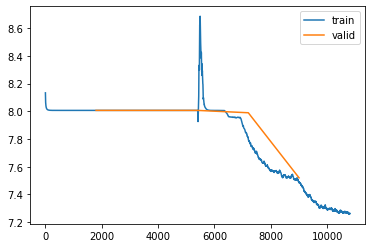

In [20]:
learn.recorder.plot_loss()